# TP Analyse scenarios IMACLIM-R - 26/10/23

Pré-requis: 
- un environnement python avec les modules demandés installés, la possibilité de travailler avec des notebook (par exemple Jupyter Lab https://jupyterlab.readthedocs.io/en/stable/getting_started/installation.html, conseil : https://github.com/lckr/jupyterlab-variableInspector pour visualiser les variables)
- le dossier data (qui contient les données) dans le répertoire de travail


Vous allez analyser des résultats de scénarios issus du modèle Imaclim-R monde (https://www.iamcdocumentation.eu/Model_Documentation_-_IMACLIM.)


Le document « ensemble scenarios ImaclimR.pdf » décrit comment un ensemble de scénarios de « baseline », i.e. sans politique climatique, a été obtenu. La base de données de scénarios est enrichie de scénarios « d’atténuation », i.e. avec un objectif de réduction des émissions de gaz à effet de serre ; un scénario d’atténuation par baseline.
Les résultats correspondants à l’ensemble de ces scénarios en termes d’émissions de CO2 (ECO2_w.csv), de PIB (GDP_w.csv) et de PIB par habitant (GDPcap_w.csv), d’intensité énergétique du PIB (EI_w.csv) et d’intensité carbone de l’énergie (CI_w.csv), à l’échelle mondiale sur la période 2015-2065, sont fournis dans le dossier /data.

Ce dossier contient également les trajectoires de population mondiale, exogène, de l’ensemble des scénarios (Pop_w.csv). Tous les résultats sont donnés en indice par rapport à la valeur 2015. La première ligne donne les années dans les fichiers de résultats. Chaque ligne suivante correspond à un scenario de la base de données de scénarios. Par ailleurs, le dossier contient également un fichier drivers.csv qui donne la combinaison des groupes de paramètres correspondant à chaque scénario (voir le fichier readme.txt pour une explication des indices du fichier drivers.csv). Dans tous les fichiers csv les scénarios sont classés dans le même ordre. 


Commencez par lire les différents documents, et par ouvrir les fichiers csv pour comprendre comment les données sont organisées.


Vous allez créer et utiliser un code python3 pour lire les données de résultats, et les analyser en traçant un certain nombre de graphiques. Le rendu du TP sera à la fois le code lui-même, et ce fichier dans lequel vous aurez copié vos graphiques et rédigé vos analyses. Vous êtes cependant libre sur le format final du rendu (codé commenté + document word/pdf, notebook...).


In [107]:

import csv
import os #lecture ecriture de csv; os management
import numpy as np #traitement de matrice de type numpy array
import matplotlib.pyplot as plt #librairy graphique
#ANOVA: fin du TD (optionnel)
from pandas import DataFrame,read_csv,concat,notnull
import glob
import pandas as pd
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols


## **A. Baselise analysis**

Description des variables (en base 1 de 2015)

|  Name |   Description  |
|---|---|
| eco2  | CO2 emissions  |
|  pop | World population   |
|  gdp_per_cap | GDP per capita  |
| gdp  | GDP |
| ei  | Energy intensity of GDP|
| ci | Carbon intensity of energy |

In [108]:
# #Reading data

# path_data='data/'

# # plusieurs manière d'importer les données, choisissez :s

# #starts at line 1 instead of zero because the line zero contains dates
# eco2 = np.array([line for line in csv.reader(open(path_data+'ECO2_w.csv','r'))][1:],dtype=float)#global CO2 emissions
# eco2 = np.genfromtxt( path_data+'ECO2_w.csv', dtype=None, delimiter=',', skip_header=1)
# eco2 = pd.read_csv( path_data+'ECO2_w.csv', delimiter=',').to_numpy()

# pop= np.array([line for line in csv.reader(open(path_data+'Pop_w.csv','r'))][1:],dtype=float)#world population

# # import other variables 
# # gdp_per_cap, gdp, ei, ci



In [109]:
# With python dictonnaries
path_data='data/'
data_tp = {}
for fil in [fil for fil in os.listdir(path_data) if '.csv' in fil]: #os.listdir(path_data) renvoie tous les fichiers dans path_data et on ne garde que les .csv
    data_tp[ fil.replace('.csv', '')] = np.array([line for line in csv.reader(open( path_data+fil,'r'))][1:],dtype=float)


In [122]:
# Loading years and the drivers' names
# # over 2015-2100 years
years = np.array([line for line in csv.reader(open('data/Pop_w.csv','r'))][0],dtype=float) #line zero zero

#avec pandas
#years = pd.read_csv( path_data+'ECO2_w.csv', delimiter=',').columns.to_numpy()

# drivers of the scenarios
drivers= np.array([line for line in csv.reader(open('data/drivers.csv','r'))][1:],dtype=float)#values of the alternative groups of parameters
drivers_names=np.array([line for line in csv.reader(open('data/drivers.csv','r'))][0],dtype=str)#names of the groups of parameters
###########################

array([2015., 2016., 2017., 2018., 2019., 2020., 2021., 2022., 2023.,
       2024., 2025., 2026., 2027., 2028., 2029., 2030., 2031., 2032.,
       2033., 2034., 2035., 2036., 2037., 2038., 2039., 2040., 2041.,
       2042., 2043., 2044., 2045., 2046., 2047., 2048., 2049., 2050.,
       2051., 2052., 2053., 2054., 2055., 2056., 2057., 2058., 2059.,
       2060., 2061., 2062., 2063., 2064., 2065.])

**Baseline description**:
Check the data/readme.txt file and pick a baselineline and describe it here.


In [111]:
#Choose a baseline (other than 2 or 77, the default value)
base_nb = 139
ind_base = base_nb-1
print(drivers[ind_base,:])

[0. 2. 2. 2. 1. 0. 1. 0.]


- *mitigation: 0 corresponds to "baseline" scenarios (no mitigation policy)*, 550 corresponds to mitigation scenarios with an emission trajectory constraint leading to a concentration of 550ppm CO2-equivalent.
- *leader growth*: 0 corresponds to "low" productivity growthin the leading region (USA), 1 to "medium" and _2 to "fast_"_;
- *productivity catch-up*: 0 corresponds to "low" productivity catch-up, 1 to "medium" and _2 to "fast"_;
- *fossil fuels*: 0 corresponds to "low" availability, _2 to "high" availability_;
- *energy demand behavior*: 0 corresponds to "energy-intensive" energy demand behavior, _1 to "energy-frugal"_;
- *energy efficiency*: _0 corresponds to "slow" end-use energy efficiency_, 1 to "mixed" (fast in rich countries but slow in low-income countries), and 2 to "fast";
- *low carbon technologies*: 0 corresponds to "low" availability of low-carbon technologies, _1 to "high" availability_;
- *labor markets rigidities*: _0 corresponds to "high" rigidities in the labor markets_, 1 to "low" rigidities.

### *A.1. Plot - CO2 emissions*
**Plot the global emissions over 2015-2065**. You could use some help of the pyplot documentation (https://matplotlib.org/)!

**How would you convert these emissions into global mean temperature increase?**.


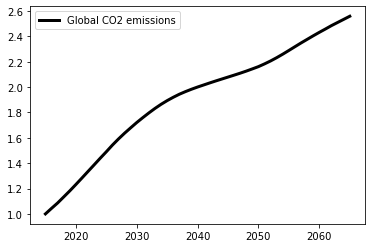

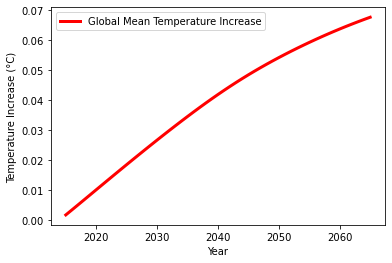

In [112]:

### Fig. 1 ###
# plot the global emissions over 2015-265
plt.figure()
plt.plot(years,np.transpose(eco2[ind_base,:]),color="k", linewidth=3, label="Global CO2 emissions")
plt.legend(loc=0)
plt.show()  
#to save it:
#plt.savefig( "ma_super_figure.pdf")
###########################

##########################
##########################

# Calculate the cumulative emissions and the global mean temperature increase
# Define the TCRE value (in °C per 1000 GtCO2)
# See Matthews et al. for more information: https://fr.wikipedia.org/wiki/R%C3%A9ponse_climatique_transitoire_aux_%C3%A9missions_cumul%C3%A9es_de_dioxyde_de_carbone
TCRE = 1.65 / 1000

# Calculate cumulative CO2 emissions (in GtCO2)
cumulative_emissions = np.cumsum(emissions) * (years[1] - years[0])  # Assuming yearly emissions

# Calculate global mean temperature increase
temperature_increase = cumulative_emissions * TCRE

### Fig. 2 ###
# Plot the global mean temperature increase over 2015-2065
plt.figure()
plt.plot(years, temperature_increase, color="r", linewidth=3, label="Global Mean Temperature Increase")
plt.xlabel('Year')
plt.ylabel('Temperature Increase (°C)')
plt.legend(loc=0)
plt.show()
# To save it:
# plt.savefig("temperature_increase.pdf")
###########################


Pic pétrolier : croissance plus faible des émissions dans la deuxième période. 

**Comments**: 

### *A. 2. Kaya identity*

As you may know, global CO2 emissions can be broken down into a product: *Population * GDP per capita * Energy intensity of GDP * Carbon intensity of GDP*. That's the Kaya identity.

**Plot the evolution of the four Kaya factors and comment, considering your choice of baseline.**

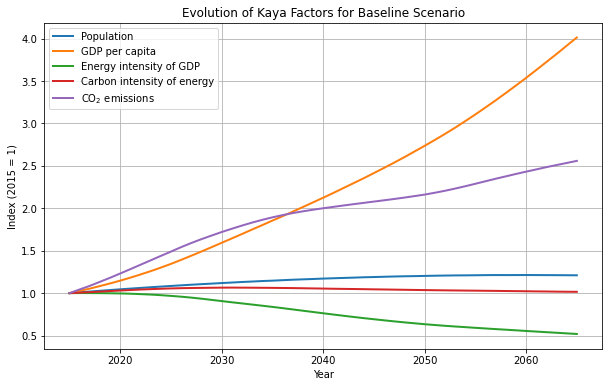

In [113]:
# Extract the data for the baseline scenario
population = data_tp['Pop_w'][ind_base, :]
gdp_per_capita = data_tp['GDPcap_w'][ind_base, :]
energy_intensity = data_tp['EI_w'][ind_base, :]
carbon_intensity = data_tp['CI_w'][ind_base, :]
emissions = data_tp['ECO2_w'][ind_base, :]

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(years, population, label='Population', linewidth=2)
plt.plot(years, gdp_per_capita, label='GDP per capita', linewidth=2)
plt.plot(years, energy_intensity, label='Energy intensity of GDP', linewidth=2)
plt.plot(years, carbon_intensity, label='Carbon intensity of energy', linewidth=2)
plt.plot(years, emissions, label='CO$_2$ emissions', linewidth=2)

plt.xlabel('Year')
plt.ylabel('Index (2015 = 1)')
plt.title('Evolution of Kaya Factors for Baseline Scenario')
plt.legend()
plt.grid(True)
plt.show()

### Comments on the Behavior of the Curves in the Graph

The graph illustrates the evolution of the Kaya factors for the baseline scenario (scenario number 139). Here are the observations and comments on the behavior of each curve:

1. **Population**:
    - The population curve shows a steady increase over the years, reflecting global population growth. This is consistent with historical trends and projections for future population growth.

2. **GDP per Capita**:
    - The GDP per capita curve also shows a consistent upward trend, indicating economic growth. This suggests that, on average, individuals are becoming wealthier over time.

3. **Energy Intensity of GDP**:
    - The energy intensity of GDP curve shows a decreasing trend. This indicates improvements in energy efficiency, meaning that less energy is required to produce a unit of GDP. This could be due to advancements in technology and shifts towards more energy-efficient practices and industries.

4. **Carbon Intensity of Energy**:
    - The carbon intensity of energy curve initially increases slightly but then starts to decrease. This suggests that the energy mix is becoming less carbon-intensive over time, possibly due to the adoption of cleaner energy sources and technologies.

5. **CO2 Emissions**:
    - The CO2 emissions curve shows an initial increase, reflecting the combined effects of population growth and economic growth. However, the rate of increase slows down over time, likely due to improvements in energy efficiency and a reduction in the carbon intensity of energy.

Overall, the baseline scenario reflects a world where economic and population growth continue, but with significant improvements in energy efficiency and a gradual shift towards cleaner energy sources. This results in a slower growth rate of CO2 emissions over time.

### *A.3. Carbon intensity and energy intensity phases*

**Plot the energy intensity of GDP (x axis) against the carbon intensity of energy (y axis). Can you identify some phases in the evolution of these two factors? How would you explain this phenomenon?**

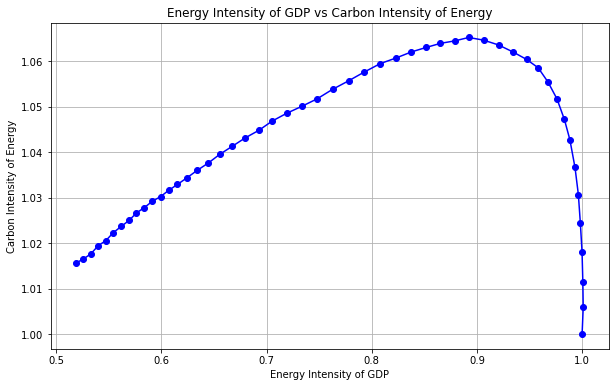

In [114]:
# Plot the energy intensity of GDP against the carbon intensity of energy
plt.figure(figsize=(10, 6))
plt.plot(energy_intensity, carbon_intensity, marker='o', linestyle='-', color='b')
plt.xlabel('Energy Intensity of GDP')
plt.ylabel('Carbon Intensity of Energy')
plt.title('Energy Intensity of GDP vs Carbon Intensity of Energy')
plt.grid(True)
plt.show()

Lire le graphique de droite à gauche : l'année 2015 est en 1;1. On trace la trajectoire d'intensité carbone en fonction de l'intensité énergétique : chaque point correspond à une année (2015 en 1;1). Dans mon scénario, quand l'intensité énergétique diminue, l'intensité carbone augmente rapidement, avant de diminuer grâce à la disponibilité de l'énergie bas-carbone. La consommation instantannée vient probablement du développement des pays du Sud (mais aller voir les hypothèses de la baseline pour en dire quelque chose !!). 

Effet de composition sectoriel + effet de composition régional.

### Phases in the Evolution of Carbon Intensity of GDP Compared to Energy Intensity of GDP

When plotting the energy intensity of GDP against the carbon intensity of energy, we can identify several phases in their evolution:

1. **Initial Phase (2015-2025)**:
    - **Energy Intensity of GDP**: There is a slight decrease in energy intensity, indicating improvements in energy efficiency.
    - **Carbon Intensity of Energy**: The carbon intensity shows a slight increase initially, suggesting a continued reliance on carbon-intensive energy sources.

2. **Transition Phase (2025-2040)**:
    - **Energy Intensity of GDP**: The energy intensity continues to decrease at a faster rate, reflecting significant advancements in energy efficiency technologies and practices.
    - **Carbon Intensity of Energy**: The carbon intensity starts to stabilize and then gradually decreases, indicating a shift towards cleaner energy sources and technologies.

3. **Stabilization Phase (2040-2065)**:
    - **Energy Intensity of GDP**: The energy intensity reaches a plateau, suggesting that the major gains in energy efficiency have been realized.
    - **Carbon Intensity of Energy**: The carbon intensity continues to decrease, albeit at a slower rate, as the energy mix becomes increasingly dominated by low-carbon and renewable energy sources.

### Explanation of the Phenomenon

The observed phases can be explained by several factors:

- **Technological Advancements**: Improvements in energy efficiency technologies and the adoption of best practices in various industries contribute to the reduction in energy intensity of GDP.
- **Policy Interventions**: Government policies and regulations aimed at reducing carbon emissions and promoting renewable energy sources play a crucial role in decreasing the carbon intensity of energy.
- **Economic Factors**: Economic growth and changes in the structure of the economy (e.g., a shift from manufacturing to services) can impact both energy and carbon intensity.
- **Behavioral Changes**: Changes in consumer behavior and increased awareness of environmental issues can lead to more energy-efficient practices and a preference for cleaner energy sources.

Overall, the interplay of these factors results in the observed phases in the evolution of carbon intensity of GDP compared to energy intensity of GDP.

## **B. Analysis of mitigation scenarios**

You are now going to analyse a mitigation scenario (carbon price) corresponding to your baseline. To do so, add 216 to the baseline number (because there are 216 baseline scenarios in the database)

In [115]:
# climat index
ind_climat = ind_base + 216

### *B. 1. Kaya identity*

**Same question as A.2. for the mitigation scenario**

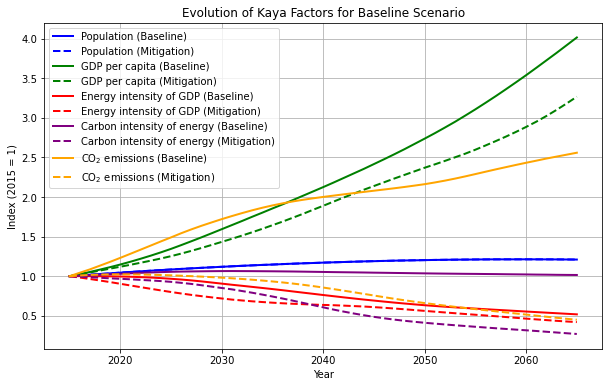

In [116]:
# Extract the data for the mitigation scenario
population = data_tp['Pop_w'][ind_climat, :]
gdp_per_capita = data_tp['GDPcap_w'][ind_climat, :]
energy_intensity = data_tp['EI_w'][ind_climat, :]
carbon_intensity = data_tp['CI_w'][ind_climat, :]
emissions = data_tp['ECO2_w'][ind_climat, :]

# Extract the data for the baseline scenario
population_baseline = data_tp['Pop_w'][ind_base, :]
gdp_per_capita_baseline = data_tp['GDPcap_w'][ind_base, :]
energy_intensity_baseline = data_tp['EI_w'][ind_base, :]
carbon_intensity_baseline = data_tp['CI_w'][ind_base, :]
emissions_baseline = data_tp['ECO2_w'][ind_base, :]

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(years, population_baseline, label='Population (Baseline)', linewidth=2, color='blue')
plt.plot(years, population, label='Population (Mitigation)', linewidth=2, linestyle='--', color='blue')

plt.plot(years, gdp_per_capita_baseline, label='GDP per capita (Baseline)', linewidth=2, color='green')
plt.plot(years, gdp_per_capita, label='GDP per capita (Mitigation)', linewidth=2, linestyle='--', color='green')

plt.plot(years, energy_intensity_baseline, label='Energy intensity of GDP (Baseline)', linewidth=2, color='red')
plt.plot(years, energy_intensity, label='Energy intensity of GDP (Mitigation)', linewidth=2, linestyle='--', color='red')

plt.plot(years, carbon_intensity_baseline, label='Carbon intensity of energy (Baseline)', linewidth=2, color='purple')
plt.plot(years, carbon_intensity, label='Carbon intensity of energy (Mitigation)', linewidth=2, linestyle='--', color='purple')

plt.plot(years, emissions_baseline, label='CO$_2$ emissions (Baseline)', linewidth=2, color='orange')
plt.plot(years, emissions, label='CO$_2$ emissions (Mitigation)', linewidth=2, linestyle='--', color='orange')

plt.xlabel('Year')
plt.ylabel('Index (2015 = 1)')
plt.title('Evolution of Kaya Factors for Baseline Scenario')
plt.legend()
plt.grid(True)
plt.show()

### *B.2. GDP: baseline vs mitigation scenario*

You may already observe on the plots that climate policies reduce GDP per capita in IMACLIM-R (or you may not!). **Compute and plot the annual GDP variation (with regard to the baseline) in the mitigation scenario. Convert it into mean annual variations at a 2030/2050/2065 horizon, and comment.**

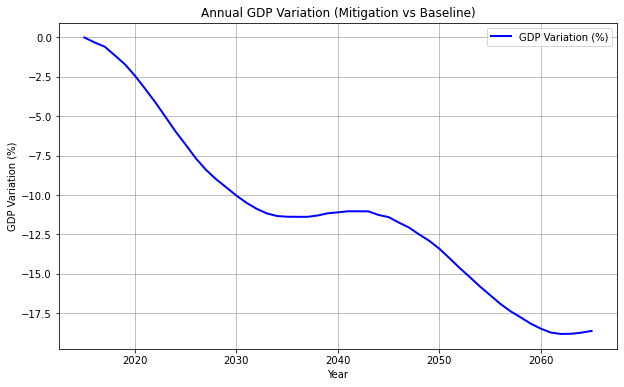

In [117]:
# Extract the GDP per capita data for the baseline and mitigation scenarios
gdp_baseline = data_tp['GDP_w'][ind_base, :]
gdp_mitigation = data_tp['GDP_w'][ind_climat, :]

# Compute the annual GDP per capita variation with regard to the baseline
gdp_variation = (gdp_mitigation - gdp_baseline) / gdp_baseline * 100

# Plot the annual GDP per capita variation
plt.figure(figsize=(10, 6))
plt.plot(years, gdp_variation, label='GDP Variation (%)', linewidth=2, color='b')
plt.xlabel('Year')
plt.ylabel('GDP Variation (%)')
plt.title('Annual GDP Variation (Mitigation vs Baseline)')
plt.legend()
plt.grid(True)
plt.show()


In [118]:
# Calculate the mean annual GDP per capita variation at 2030, 2050, and 2065 horizons

##################
###### FAUX ######
##################

# mean_variation_2030 = np.mean(gdp_per_capita_variation[years <= 2030])
# mean_variation_2050 = np.mean(gdp_per_capita_variation[years <= 2050])
# mean_variation_2065 = np.mean(gdp_per_capita_variation[years <= 2065])

# print(f"Mean annual GDP per capita variation by 2030: {mean_variation_2030:.2f}%")
# print(f"Mean annual GDP per capita variation by 2050: {mean_variation_2050:.2f}%")
# print(f"Mean annual GDP per capita variation by 2065: {mean_variation_2065:.2f}%")


#### JUSTE #####
## Le taux de croissance moyen n'est pas égal à la moyenne des taux de croissance !!

def gdp_growth_loss(gdp_ref, gdp_new, ind_year):
    growth_ref = gdp_ref[ind_year] / gdp_ref[0]
    growth_new = gdp_new[ind_year] / gdp_new[0]
    return (growth_ref ** (1/ind_year) - growth_new ** (1/ind_year))*100

## On ne divise pas par le taux de coissance initial dans return car il est égal à 1. 

print([gdp_growth_loss(data_tp['GDP_w'][ind_base], data_tp['GDP_w'][ind_climat], i - 2015) for i in [2030, 2050, 2065]])


[0.7307722395654803, 0.42497303826103394, 0.42470808710748376]


Our mitigation scenario reduces more and more GDP/capita as time goes by. Les mesures de mitigations (= la taxe carbone) affecte la croissance. Niveau de taxe carbone à + de 200$\tCO2 ; redistribution uniforme, prix unique. Distorsion de productivité pour les entreprises. Courbe stagne : PIB équivalent. Présence de ressources pétrolières abondantes ne permet pas de réduire la différence avec une baseline qui aurait pû 

## **C. Analysis of a Scenario set**

Sometimes, scenario analysis deals with a large number of scenarios that need to be compared globally.

### *C.1. Baseline scenario database: cumulated emissions vs mean annual growth plot*

**Compute the cumulated CO2 emissions and the mean annual growth between 2015 and 2065 in the set of baseline scenario and plot the results**. Hint: every scenario should be a point on the graph, with the mean annual growth on the x axis and the cumulated CO2 emissions on the y axis.

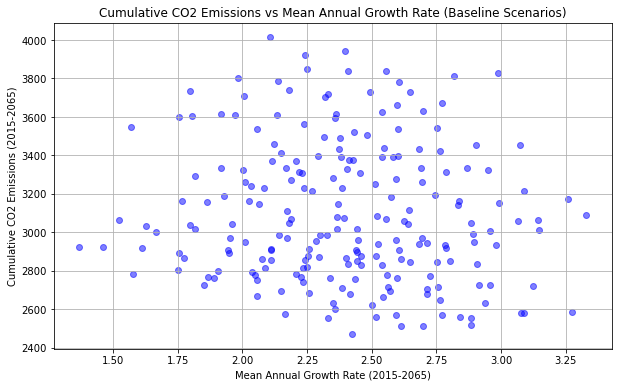

In [119]:
#### FAUX #### À recoder : ne pas prendre en compte les baselines.

# Calculate the cumulative CO2 emissions for each baseline scenario
Emi_2015_GtCO2 = 35.2 # See Matthews ! 
cumulative_emissions_baseline = data_tp['ECO2_w'].sum(axis=1) * Emi_2015_GtCO2

# Calculate the mean annual growth rate for each baseline scenario
grow_mean = 100 * (data_tp['GDPcap_w'][:,-1] ** (1. / data_tp['GDPcap_w'].shape[1]) - 1)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(grow_mean[0:216], cumulative_emissions_baseline[0:216], color='b', alpha=0.5)
plt.xlabel('Mean Annual Growth Rate (2015-2065)')
plt.ylabel('Cumulative CO2 Emissions (2015-2065)')
plt.title('Cumulative CO2 Emissions vs Mean Annual Growth Rate (Baseline Scenarios)')
plt.grid(True)
plt.show()

### *C.2. Baseline + Mitigation scenario database: mean annual growth*

**Plot on the same histogram the mean annual growth in the baseline vs mitigation scenarios. Comment**. Hint: use the plt.hist function

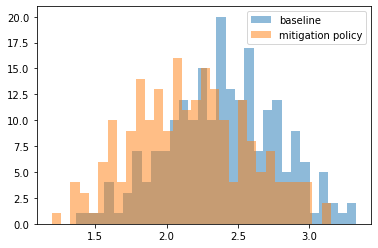

In [120]:
plt.hist(grow_mean[0:216], alpha = 0.5, label = 'baseline', bins = 30)
plt.hist(grow_mean[216:], alpha = 0.5, label = 'mitigation policy', bins = 30)
plt.legend(loc='upper right')

Possible de répondre à un budget carbone donné avec une croissance économique positive (bien qu'impactée).

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe0410101f0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe041010790>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe040f22ee0>,
 'medians': [<matplotlib.lines.Line2D at 0x7fe041010d30>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fe04101e040>,
 'means': []}

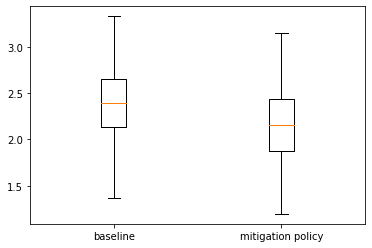

In [121]:
plt.boxplot((grow_mean[0:216], grow_mean[216:]), labels = ['baseline', 'mitigation policy'])

### *C.3. Analysis of variance (ANOVA) - for those who have time* 

**Choose a model's output (CO2 emissions or economic growth) in a scenario subset, either baseline or mitigation. Perform an ANalysis Of VAriance on this scenario subset to analyse the inputs' contribution to the total variance of the results.**.  

Hints:
- you will want to use the anova module https://www.statsmodels.org/dev/examples/notebooks/generated/interactions_anova.html 
- ANOVA consists first of a linear model (Y ~ X with X the set of exogenous drivers)
- then, decompose the total variance (in %) by each regressor's contribution + the interaction of regressors' contribution and plot it